In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib

from joypy import joyplot

from shapely import geometry

from geopandas.tools import sjoin
from geopandas import GeoDataFrame
import geopandas as gpd

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import Polygon


import math

from math import radians, cos, sin, asin, sqrt

#from Functions import *
import Functions
print('loaded libraries')

loaded libraries
loaded libraries


In [2]:
def calculateHaversine(lon1, lat1, lon2, lat2):
    #Calculate Haversine Distance
    EARTH_RADIUS = 6371;

    lat1, lon1, lat2, lon2 = map(radians,
                                 [lat1,
                                  lon1,
                                  lat2,
                                  lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    
    return EARTH_RADIUS * c * 1000;

def get_all_files_in_folder(folder_path):
    """
    Read files from folder
    input: folder path
    output: all files in that folder
    
    """
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

def transformJavaRouteToPlottingRoute(route):
    """
    Java required to add an "_" (underscore) for reading csv files lines as string (?) so all routes got the _
         when creating the graphs. Must delete it for search in python.
    input: route string
    output: route elemenets as int and as string
    """
    
    route = route.replace('[','').replace(']','').replace(' ','')#.replace('_','')
    route = route.split(',')
    routeInt = []
    route_ = []
    for i in route:
        routeInt.append(int(i.replace('_','')))
    for i in route:
        route_.append(i+'_')
    return routeInt, route_

def assignWeights(G, path_nodes_in_grid, path_grid_geom):
    """
    Follow logic to assign nodes and edges weights from pollution grid
    input: G (graph), nodes in grid (for each tile), path for pollution grid
    output:
    
    """
    nodes = ox.graph_to_gdfs(G, edges=False) # obtain node as df
    edges = ox.graph_to_gdfs(G, nodes=False) # obtain edges as df
    edges = edges.reset_index()

    # Load dataframes (make sure you are loading the pollution and nodes you actually want)
    # if you load an incorrect graph, nodes will not match & process will crash
    
    
    nodesJava = pd.read_csv(path_nodes_in_grid)
    gridGeom = pd.read_csv(path_grid_geom) 
    
    gridGeom['code'] = gridGeom.index # make the code of the grid the index for easier search
    
    # Merge dataframe
    nodesJava = nodesJava.merge(gridGeom, how='left', on='code')
    nodesJava.set_index('id', inplace = True)
    
    node = {}
    edgePollution = []
    
    # Assign value to edge
    
    for index,row in edges.iterrows():

        try:
            #print('processed')
            u_p = nodesJava.loc[str(row["u"])+'_']["predicted_pm2.5"]
            v_p = nodesJava.loc[str(row["v"])+'_']["predicted_pm2.5"]
            edgePollution.append((float(u_p)+float(v_p))/2)
            
        except:

            #print('couldnt process', row["u"], row["v"])
            edgePollution.append((float(u_p)+float(v_p))/2)
            
    edges['Pollution'] = edgePollution # Assign pollution to edges dataframe

    return nodesJava, edges


def createPredictionBased2(shortest_path_points):
    """
    Assign values to your route 
    So obtain the actual value of that edge length and the pollution calculated before
    input: route as df
    output: updated route as df
    
    """
    
    predicted2 = [0]
    predicted1 = [0]
    thatEdgeLength=[0]
    print('length route', len(shortest_path_points))
    for i in range(len(shortest_path_points.index) - 1):
        
        u = shortest_path_points.index[i][:-1]
        v = shortest_path_points.index[i+1][:-1]
        
        #print(i, shortest_path_points.index[i], shortest_path_points.index[i + 1], ' --->',u, v)
        
        edge = edges[(edges['u'] == int(u)) & (edges['v'] == int(v))]
        
        pollution = edge['Pollution'].tolist()
        #print(pollution)
        length = edge['length'].tolist()
        predicted1.append(pollution[0])
        thatEdgeLength.append(length[0])
        
    shortest_path_points['predicted_V1'] = predicted1
    shortest_path_points['thatEdgeLength'] = thatEdgeLength

    return(shortest_path_points)

def createCumulativeSimpleSum(cleanest_path_points, typeOfPollutant):
    """ 
    create Cumulative Simple Sum
    input dataframe, real or predicted pollutants column name
    output updated dataframe
    """
    
    cumulativeSimpleSum = []
    cumulativeSimpleSumValue = 0
    n = 0
    for i in cleanest_path_points[typeOfPollutant]:
        if n != len(cleanest_path_points[typeOfPollutant]):
            cumulativeSimpleSumValue = cumulativeSimpleSumValue + i
            #print(i)
            cumulativeSimpleSum.append(cumulativeSimpleSumValue)
        n = n + 1
    #print(cumulativeSimpleSumValue)
    cleanest_path_points["cumulativeSimpleSum"] = cumulativeSimpleSum
    
    return cleanest_path_points

## Load Graph

In [3]:
# Load Graph
G = ox.load_graphml('./data/ProcessedGraphs/8000/squared-grid.graphml')
print(G)

# Load appropriate nodes assigned to tiles file
path_nodes_in_grid = './data/ProcessedGraphs/8000/nodes-in-grid.csv' 


MultiDiGraph with 21208 nodes and 61844 edges


## LOAD ROUTES AND POLLUTION GRID [!]

Select the real route AND make sure you also choose the correct prediction grid for the hour and time.

All route 1 are at 7 am, all route 2 are for 8 am and all route 3 are for 9 am.

In [4]:
# LOAD APPROPRIATE FILES

# ------------------ LOAD THE CORRECT POLLUTION GRID (MATCH DAY AND HOUR) [!] ------------------
path_grid_geom = './data/Predictions/20JulyCorrected/2023_08_03_07_00_00.csv'

nodesJava, edges = assignWeights(G, path_nodes_in_grid, path_grid_geom) #assign weights to the nodes
# ----------------------------------------------------------------------------------------------


# ------------------ Load Real Route ------------------
#           BE SURE TO LOAD THE CORRECT ROUTE [!]

#real = pd.read_csv('./LondonJourneysProcessed/2023-07-28AirSpeckLogsOutdoorWalkingF44182EC762B__route_1.csv')
#real = pd.read_csv('./LondonJourneysProcessed/2023-07-28AirSpeckLogsOutdoorWalkingF28ABF2B57EA__route_3.csv')
#real = pd.read_csv('./LondonJourneysProcessed/2023-08-01AirSpeckLogsOutdoorWalkingF28ABF2B57EA__route_2.csv')
#real = pd.read_csv( "./LondonJourneysProcessed/2023-08-02AirSpeckLogsOutdoorWalkingF28ABF2B57EA__route_1.csv")
real = pd.read_csv("./LondonJourneysProcessed/2023-08-03AirSpeckLogsOutdoorWalkingF28ABF2B57EA__route_1.csv")

# ------------------------------------------------------
#20 August
title = '20 July 2023 - Route 1'

# 1
route = "[9300, 9298, 9299, 10576, 10445, 10442, 10444, 10461, 10460, 10458, 10459, 2368, 1130, 1101, 1098, 1100, 1105, 1110, 1106, 1107, 1111, 1113, 1121, 1638, 1634, 1639, 5477, 1125, 1633, 10477, 10475, 5496, 1689, 1688, 1685, 1679, 1686, 1684, 1681, 1683, 9368, 5883, 5879, 283, 282, 283, 13259, 9327, 9324, 9323, 9325, 9470, 6312, 6311, 302, 6315, 6316, 294, 8115, 8117, 9346, 9345, 8113, 8111, 8112, 10602, 10599, 296, 297, 4577, 2582, 2580, 2583, 1410, 1408, 1412, 6506, 1406, 1404, 1405, 6493, 3588, 3584, 9206, 9205, 12364, 14046, 17222, 17221, 17220]"
# 2
route = "[3605, 3606, 3856, 3853, 3851, 3854, 3887, 3865, 3862, 3863, 3866, 3868, 3599, 3596, 3597, 3583, 9216]"
# 3
route = "[6320, 281, 277, 278, 13258, 284, 283, 5879, 5883, 9368, 1683, 5511, 1729, 1728, 1726, 1724, 1723, 5498, 5494, 5478, 1125, 5477, 1639, 1634, 1638, 1121, 1113, 1111, 1107, 1106, 1110, 1105, 1100, 1098, 1101, 1130, 2368, 10459, 10458, 10460, 10461, 10444, 10442, 10445, 10576, 9299, 9298, 9300]"


# no data for 27
# 28 July
# 1
title = '28 July 2023 - Route 1'

route = "[10442, 10444, 10461, 10460, 10458, 10459, 2368, 1130, 1101, 1098, 1100, 1105, 1110, 1106, 1107, 1111, 1113, 1122, 1128, 18779, 1128, 1124, 1127, 6255, 9385, 9384, 5497, 5494, 5498, 1723, 1724, 1726, 1728, 1729, 5511, 1683, 9368, 5883, 5879, 283, 13259, 9327, 9324, 9323, 9325, 9470, 6312, 6311, 302, 6315, 6316, 294, 8115, 8117, 9346, 9345, 8113, 12500, 8113, 8111, 8112, 10602, 10599, 296, 297, 4577, 2582, 2580, 2583, 1410, 1408, 1411, 3586, 3584, 9206, 9205, 12364, 2610, 2608, 2612, 3848, 3849, 17219]"
#2
route = "[3856, 3853, 3851, 3854, 3887, 3602, 3865, 3862, 3863, 3866, 3868, 3599, 3596, 3597, 3598, 9211, 3579, 3576, 3578, 3581, 271, 3582]"
#3
route = "[3582, 271, 270, 268, 269, 276, 274, 6319, 6317, 6320, 281, 277, 278, 13258, 284, 282, 283, 5879, 5883, 9368, 1683, 5511, 1729, 1728, 1726, 1724, 1723, 5498, 5494, 5478, 1125, 5477, 1639, 1634, 1638, 1121, 1113, 1111, 1107, 1106, 1110, 1105, 1100, 1098, 1101, 1130, 2368, 10459, 10458, 10460, 10461, 10444, 10442, 10445, 10576, 9299, 9298, 9300]"

# 01 August
title = '01 August 2023 - Route 1'

# 1
route = "[9300, 9298, 9299, 10576, 10445, 10442, 10444, 10461, 10460, 10458, 10459, 2368, 1130, 1101, 1098, 1100, 1105, 1110, 1106, 1107, 1111, 1113, 1121, 1638, 1634, 1639, 5477, 1125, 5478, 5494, 5498, 1723, 1724, 1726, 1728, 1729, 5511, 1683, 9368, 5883, 5879, 283, 13259, 9327, 9324, 9323, 9325, 9470, 6312, 6311, 302, 6315, 6316, 294, 8115, 8117, 9346, 9345, 8113, 8111, 8112, 10602, 10599, 296, 297, 4577, 2582, 2580, 2583, 1410, 1408, 1412, 6506, 1406, 1404, 1405, 6493, 3588, 3584, 9206, 9205, 12364, 14046, 17222, 17221, 17220]"
# 2
route = "[14048, 3855, 3851, 3854, 3887, 3865, 3862, 3863, 3866, 3868, 3599, 3596, 3597, 3583, 9216, 10297, 3580]"

# 02 August (just 1 route)
title = '02 August 2023 - Route 1'

route = "[9300, 9298, 9299, 10576, 10445, 10442, 10444, 10461, 10460, 10458, 10459, 2368, 1130, 1101, 1098, 1100, 1105, 1110, 1106, 1107, 1111, 1113, 1121, 1638, 1634, 1639, 5477, 1125, 1633, 10477, 10475, 5496, 1689, 1688, 1685, 1679, 1686, 1684, 1681, 1683, 9368, 5883, 5879, 283, 282, 283, 13259, 9327, 9324, 9323, 9325, 9470, 6312, 6311, 302, 6315, 6316, 294, 8115, 8117, 9346, 9345, 8113, 8111, 8112, 10602, 10599, 296, 297, 4577, 2582, 2580, 2583, 1410, 1408, 1412, 6506, 1406, 1404, 1405, 6493, 3588, 3584, 9206, 9205, 12364, 14046, 17222, 17221, 17220, 17219, 3605]"

# 03 August 

title = '03 August 2023 - Route 2'

#route ="[9300, 9298, 9299, 10576, 10445, 10442, 10444, 10260, 10259, 10261, 10256, 10255, 10254, 2369, 5876, 5872, 5874, 9784, 9776, 9773, 1627, 1626, 1630, 11085, 1632, 1631, 1635, 10481, 10479, 10478, 8242, 8241, 8244, 6243, 5495, 6242, 1678, 1674, 1672, 1671, 5510, 5500, 5499, 5502, 5518, 8053, 5518, 5516, 5517, 10513, 10511, 269, 268, 6325, 6324, 266, 265, 10297, 9216, 3583, 3597, 3596, 3599, 3868, 3601, 3865, 3887, 3854, 3851, 3853, 3856, 3606, 3605]"
route = "[9300, 9298, 9301, 10263, 10262, 10259, 10261, 10256, 10255, 10254, 2369, 5876, 5872, 5874, 9784, 9781, 9782, 9775, 9786, 9787, 9788, 10478, 8242, 8241, 8244, 6243, 5481, 5479, 1676, 1672, 1671, 5510, 5500, 5499, 5502, 5518, 5516, 5517, 10513, 10511, 269, 268, 270, 271, 3583, 3597, 3596, 3599, 3868, 3601, 3865, 9318, 9208, 12362, 12364, 14046, 3607, 17220]"

print(route)

[9300, 9298, 9301, 10263, 10262, 10259, 10261, 10256, 10255, 10254, 2369, 5876, 5872, 5874, 9784, 9781, 9782, 9775, 9786, 9787, 9788, 10478, 8242, 8241, 8244, 6243, 5481, 5479, 1676, 1672, 1671, 5510, 5500, 5499, 5502, 5518, 5516, 5517, 10513, 10511, 269, 268, 270, 271, 3583, 3597, 3596, 3599, 3868, 3601, 3865, 9318, 9208, 12362, 12364, 14046, 3607, 17220]


## Plot route against longitude and latitude

,latitude,longitude,code,predicted_pm2.5,geometry
id,,,,,
9300_,-0.214546,51.525233,3420,4.703222,-0.2134089135747362 51.524426903026246_ -0.21...
9298_,-0.213874,51.524069,3419,5.542214,-0.2134089135747362 51.523399106905195_ -0.21...
9301_,-0.213461,51.524047,3419,5.542214,-0.2134089135747362 51.523399106905195_ -0.21...
10263_,-0.211648,51.523654,3279,6.131964,-0.2101069268709307 51.523399106905195_ -0.21...
10262_,-0.212256,51.522946,3348,6.064356,-0.2117579202228335 51.522371310784145_ -0.21...


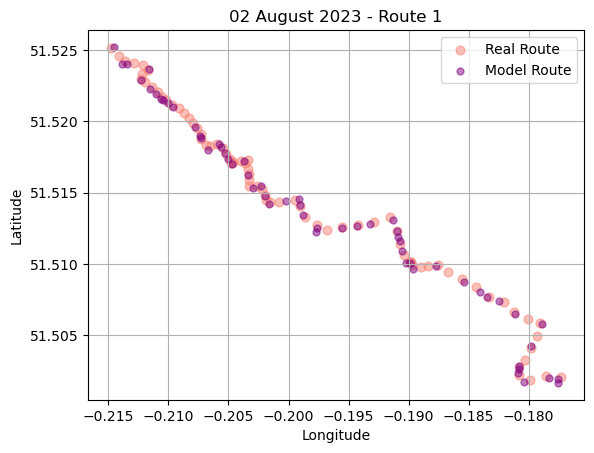

In [5]:
# Plot route 
routeInt, route_ = transformJavaRouteToPlottingRoute(route)
#route_ = route_[::-1] #reverse route   
shortest_path_points = nodesJava.loc[route_] 
display(shortest_path_points.head())

fig, ax = plt.subplots()
plt.scatter(real["gpsLongitude"], real["gpsLatitude"], s= 40, c='salmon',  label = 'Real Route',alpha=0.5)
plt.scatter(shortest_path_points["latitude"], shortest_path_points["longitude"], s=25, label = 'Model Route', c='purple', alpha=0.5)
plt.legend()
plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_RouteFollowed.png')
plt.show()


## Plot PM2.5 against Longitude of the route

length route 58


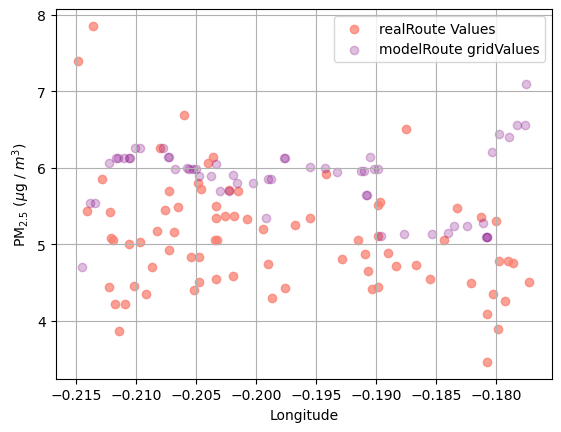

In [6]:

from shapely import geometry
from shapely.geometry import Point

# convert values to geometry point objects
points = []
for index, row in real.iterrows():
    points.append(Point(row['gpsLongitude'],row['gpsLatitude'])) 

real['geometry'] = points

shortest_path_points = createPredictionBased2(shortest_path_points)

fig, ax = plt.subplots()
plt.scatter(real["gpsLongitude"], real["pm2_5"], c='salmon', alpha=0.75, label = 'realRoute Values')
plt.scatter(shortest_path_points.latitude, shortest_path_points["predicted_pm2.5"], c='purple', alpha=0.25, label = 'modelRoute gridValues')

plt.legend()
plt.ylabel('PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.xlabel('Longitude')
plt.grid()
fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_cumDSimplePol.png')
plt.show()



## Obtain cumulative distance

In [8]:

totalIndex = len(shortest_path_points.index)
count = 0
sumDistance = 0
indexList = shortest_path_points.index.tolist()
cumulativeDistance = [0]

for index, row in shortest_path_points.iterrows():
    
    if count < totalIndex - 1:
        nextRow = shortest_path_points.loc[indexList[count + 1]]
        
        if isinstance(nextRow.thatEdgeLength, pd.Series):
            edgeLength = nextRow.thatEdgeLength[0]
        else:
            edgeLength = nextRow.thatEdgeLength

        sumDistance = sumDistance + edgeLength
        cumulativeDistance.append(sumDistance)
        
    count = count +1
    
print('Model Data Cumulative Distance:',cumulativeDistance[-1] )      
shortest_path_points['cumulativeDistance'] = cumulativeDistance


Model Data Cumulative Distance: 4829.934084132703


## plot values arranged by distance traversed

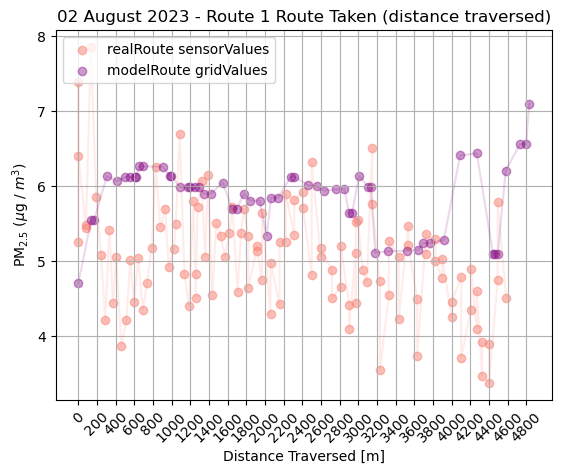

In [9]:
value = 200 # how much distance between sum
# Plot
fig, ax = plt.subplots()

ax.scatter(real["cumulativeDistance"], real["pm2_5"], c='salmon', alpha=0.5, label = 'realRoute sensorValues')
ax.plot(real["cumulativeDistance"], real["pm2_5"], c='salmon', alpha=0.15)

ax.scatter(shortest_path_points['cumulativeDistance'], shortest_path_points["predicted_pm2.5"], c='purple', alpha=0.4, label = 'modelRoute gridValues')
ax.plot(shortest_path_points["cumulativeDistance"], shortest_path_points["predicted_pm2.5"], c='purple', alpha=0.15)

#plt.scatter(predicted_["gpsLongitude"], predicted_["predicted_pm2.5"], c='steelblue', alpha=0.25)
xticks = ax.get_xticks()

# Create new xticks with more vertical lines
new_xticks = np.arange(0, shortest_path_points['cumulativeDistance'][-1], value)
#new_xticks = np.arange(0, 5000, value)

# Set the xticks
ax.set_xticks(new_xticks)
plt.xticks(rotation=45)
color = ['steelblue','navy','cornflowerblue','royalblue']
plt.title(title + ' Route Taken (distance traversed)')
plt.legend(loc= 'upper left')
plt.grid()
plt.xlabel('Distance Traversed [m]')
plt.ylabel('PM$_{2.5}$ ($\mu$g / $m^3$)')
#fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_cumDSimplePol_.png')
plt.show()

## Compute simplified dataframes with avg values only

In [10]:

nextLim = 200 # limit between averages
value = 200 # range between averages
avgPollution = []
dictionary = {'avgPollution':[], 'cumulativeDistance':[], 'sumPollution':[]}
pollution = []
sumPollution = 0

# iterate rows
for index, row in shortest_path_points.iterrows():

    if row['cumulativeDistance'] < nextLim:
        
        pollution.append(row['predicted_pm2.5'])
        
    else:

        if len(pollution) == 0:

            pollution = dictionary['avgPollution'][-1]
            
        sumPollution = sumPollution + np.mean(pollution)
        dictionary['avgPollution'].append(np.mean(pollution))
        dictionary['cumulativeDistance'].append(nextLim)
        dictionary['sumPollution'].append(np.mean(sumPollution))
        pollution = []
        pollution.append(row['predicted_pm2.5'])
        nextLim = nextLim + value
                
shortestValues = pd.DataFrame(dictionary)

nextLim = 200
value = 200

avgPollution = []
dictionary = {'avgPollution':[], 'cumulativeDistance':[], 'sumPollution':[]}
pollution = []
sumPollution = 0
for index, row in real.iterrows():

    if row['cumulativeDistance'] < nextLim:
        #print(row['cumulativeDistance'], row['predicted_pm2.5'], nextLim)
        pollution.append(row['pm2_5'])
    else:
        #print(pollution)
        sumPollution = sumPollution + np.mean(pollution)
        dictionary['avgPollution'].append(np.mean(pollution))
        dictionary['cumulativeDistance'].append(nextLim)
        dictionary['sumPollution'].append(np.mean(sumPollution))
        pollution = []
        pollution.append(row['pm2_5'])
        nextLim = nextLim + value
            
realValues = pd.DataFrame(dictionary)

print("simplified dataframes created")

simplified dataframes created


## plot combined averaged values (step plot) and total sum 

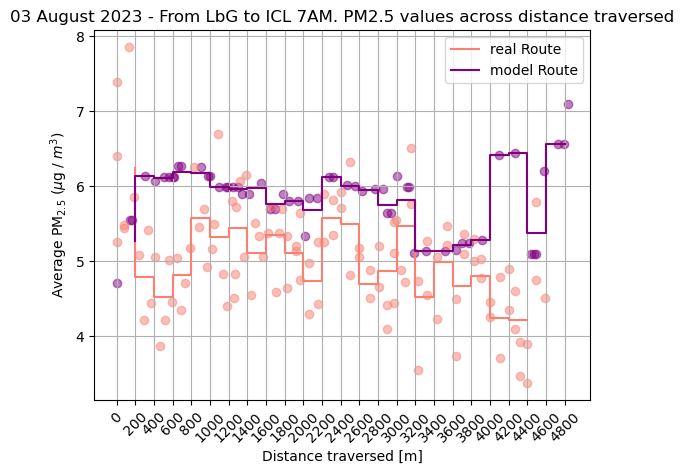

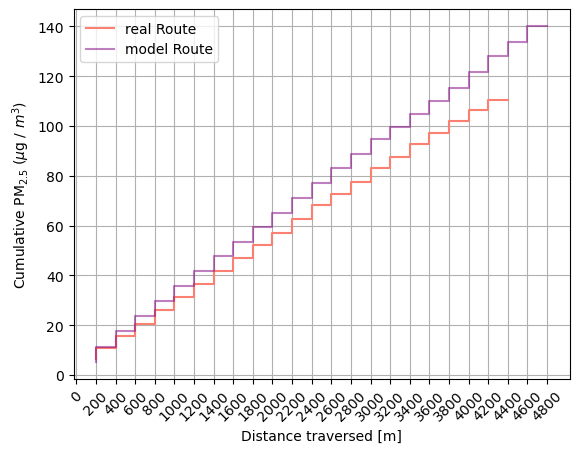

In [11]:


# --------------------------

fig, ax = plt.subplots()
ax.step(realValues["cumulativeDistance"], realValues['avgPollution'],  c='salmon', where='pre', label='real Route')
ax.scatter(shortest_path_points["cumulativeDistance"], shortest_path_points["predicted_pm2.5"], c='purple', alpha=0.5)
ax.scatter(real["cumulativeDistance"], real["pm2_5"], c='salmon', alpha=0.5)
ax.step(shortestValues["cumulativeDistance"], shortestValues['avgPollution'],  c='purple', where='pre', label='model Route')
xticks = ax.get_xticks()

# Create new xticks with more vertical lines
#new_xticks = np.arange(0, xticks[-1], value)

# Set the xticks
ax.set_xticks(new_xticks)
plt.xticks(rotation=45)
color = ['steelblue','navy','cornflowerblue','royalblue']
plt.title("03 August 2023 - From LbG to ICL 7AM. PM2.5 values across distance traversed")
plt.legend()
plt.xlabel('Distance traversed [m]')
plt.ylabel('Average PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.grid()
fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_AvgPm25wMean_onePlot.png')
plt.show()


## new plot
fig, ax = plt.subplots()

plt.step(realValues["cumulativeDistance"], realValues['sumPollution'],  c='salmon', where='pre', label='real Route')
plt.step(shortestValues["cumulativeDistance"], shortestValues['sumPollution'],  c='purple', alpha=0.5,
         where='pre', label='model Route')

xticks = ax.get_xticks()

# Set the xticks
ax.set_xticks(new_xticks)
plt.xticks(rotation=45)

plt.legend()
plt.xlabel('Distance traversed [m]')
plt.ylabel('Cumulative PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.grid()
#fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_DTCumPol.png')
plt.show()


## plot linear comparison

done


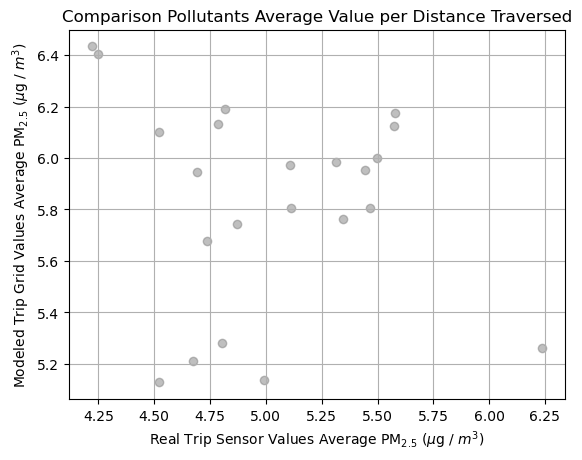

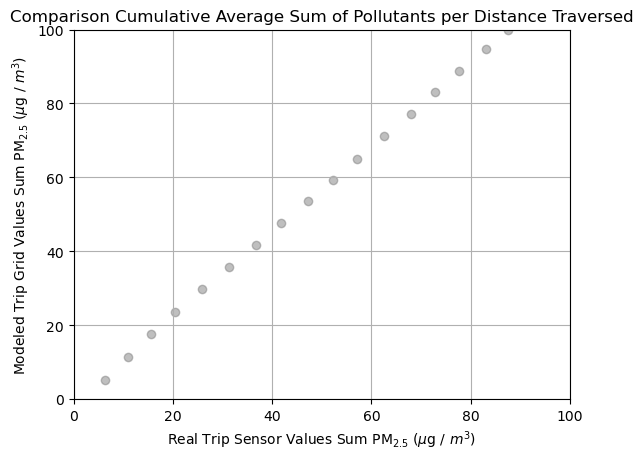

In [12]:

realValues_ = realValues.copy()
shortestValues_ = shortestValues.copy()
while len(realValues_.index) != len(shortestValues_.index):
    shortestValues_ = shortestValues_.drop(index=shortestValues_.index[-1])
print('done')
fig, ax = plt.subplots()

plt.scatter(realValues_["avgPollution"], shortestValues_["avgPollution"], c='grey', alpha=0.5)
plt.xlabel('Real Trip Sensor Values Average PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.ylabel('Modeled Trip Grid Values Average PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.title('Comparison Pollutants Average Value per Distance Traversed')
#fig.savefig('./Results/'+ title.replace(' ','_')+'_ComparisonPollAvgDt.png')
plt.grid()
plt.show()

fig, ax = plt.subplots()

plt.scatter(realValues_["sumPollution"], shortestValues_["sumPollution"], c='grey', alpha=0.5)
plt.xlabel('Real Trip Sensor Values Sum PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.ylabel('Modeled Trip Grid Values Sum PM$_{2.5}$ ($\mu$g / $m^3$)')
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('Comparison Cumulative Average Sum of Pollutants per Distance Traversed')
plt.grid()
plt.show()
#fig.savefig('./Results/'+ title.replace(' ','_')+'_ComparisonCumSumPol.png')

## plot values side by side

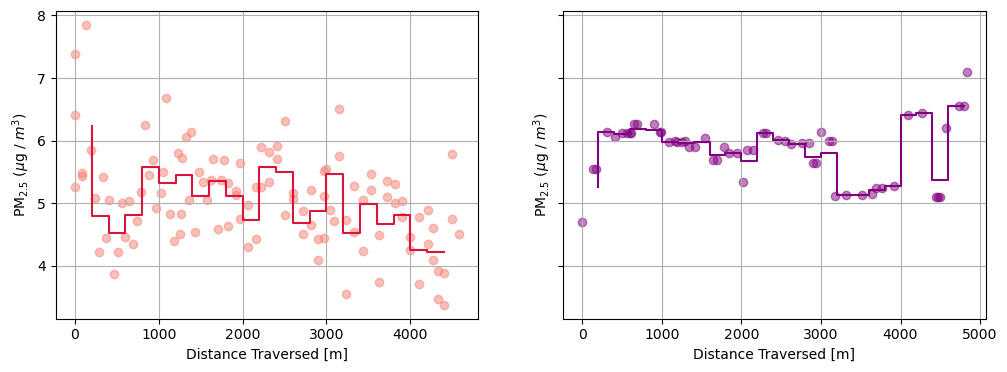

In [13]:
#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].scatter(real["cumulativeDistance"], real["pm2_5"], c='salmon', alpha=0.5)
ax[0].step(realValues["cumulativeDistance"], realValues['avgPollution'],  c='crimson', where='pre', label='realRoute avgValues')
ax[0].set_xlabel('Distance Traversed [m]')
ax[0].set_ylabel('PM$_{2.5}$ ($\mu$g / $m^3$)')
ax[0].grid(True)

ax[1].scatter(shortest_path_points["cumulativeDistance"], shortest_path_points["predicted_pm2.5"], c='purple', alpha=0.5)
ax[1].step(shortestValues["cumulativeDistance"], shortestValues['avgPollution'],  c='purple', where='pre', label='modelRoute avgValues')
ax[1].set_xlabel('Distance Traversed [m]')
ax[1].set_ylabel('PM$_{2.5}$ ($\mu$g / $m^3$)')
ax[1].grid(True)

#fig.savefig('./Results/'+ title.replace(' ','_')+'_AvgPm25wMean_SubPlots.png')


## plot simple cumulative sum

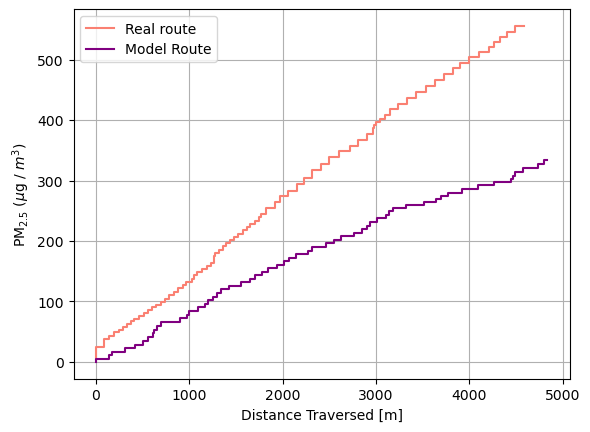

In [14]:
shortest_path_points = createCumulativeSimpleSum(shortest_path_points, "predicted_V1")
real= createCumulativeSimpleSum(real, "pm2_5")

fig, ax = plt.subplots()
ax.step(real["cumulativeDistance"], real['cumulativeSimpleSum'],  c='salmon', where='pre', label='Real route')
ax.step(shortest_path_points["cumulativeDistance"], shortest_path_points['cumulativeSimpleSum'],  c='purple', where='pre', label='Model Route')
plt.xlabel('Distance Traversed [m]')
plt.ylabel('PM$_{2.5}$ ($\mu$g / $m^3$)')
#plt.axvline(x=parkStarts, color='red', linestyle='--', label='Park Starts')
plt.legend()
plt.grid()
#fig.savefig('./Results/'+ title.replace(' ','_').replace('/','_')+'_DtraversedSimpleCumPol.png')


## Create Text file with results

In [15]:


String = title + '\n'
String = String + 'Real ' + str(real["cumulativeDistance"].tolist()[-1]) + ', ' + str(real['cumulativeSimpleSum'].tolist()[-1]) + '\n'
String = String + 'Model ' + str(shortest_path_points["cumulativeDistance"][-1]) + ', '+ str(shortest_path_points['cumulativeSimpleSum'][-1]) + '\n'
String = String + 'Real Avg Sum: ' + str(realValues["cumulativeDistance"].tolist()[-1]) +', '+ str(realValues['sumPollution'].tolist()[-1]) + '\n'
String = String + 'Model Avg Sum: ' + str(shortestValues["cumulativeDistance"].tolist()[-1]) +', '+  str(shortestValues['sumPollution'].tolist()[-1]) + '\n'
#print(String)

#print(shortest_path_points.index)
srcNode = int(shortest_path_points.index[0][:-1])
tarNode = int(shortest_path_points.index[-1][:-1])

routeCleanest = nx.shortest_path(G, srcNode, tarNode, 'Pollution')
routeShortest = nx.shortest_path(G, srcNode, tarNode, 'length')
 
sumPollution = 0
sumLength = 0
for i in range(len(routeShortest) - 1):
    u = routeShortest[i]
    v = routeShortest[i+1]
    edge = edges[(edges['u'] == int(u)) & (edges['v'] == int(v))]
    sumPollution += edge['Pollution'].tolist()[0]
    sumLength +=  edge['length'].tolist()[0]
#print('Shortest sumPollution',sumPollution)
#print('Shortest sumLength',sumLength)
String = String + 'Shortest sumPollution: ' + str(sumPollution) + '\n'
String = String + 'Shortest sumLength: ' + str(sumLength)+ '\n'

sumPollution = 0
sumLength = 0
for i in range(len(routeCleanest) - 1):
    u = routeCleanest[i]
    v = routeCleanest[i+1]
    edge = edges[(edges['u'] == int(u)) & (edges['v'] == int(v))]
    sumPollution += edge['Pollution'].tolist()[0]
    sumLength +=  edge['length'].tolist()[0]
#print('Cleanest sumPollution',sumPollution)
#print('Cleanest sumLength',sumLength)
String = String + 'Cleanest sumPollution: ' + str(sumPollution) + '\n'
String = String + 'Cleanest sumLength: ' + str(sumLength)+ '\n'

print(String)

# uncomment this
#f = open('./Results/'+ title.replace(' ', '') + ".txt", "a")
#f.write(String)
#f.close()


02 August 2023 - Route 1
Real 4583.578770675984, 555.6496255999999
Model 4829.934084132703, 333.60055249999994
Real Avg Sum: 4400, 110.55809361369047
Model Avg Sum: 4800, 140.15915694166668
Shortest sumPollution: 473.12772910000035
Shortest sumLength: 4378.370965290627
Cleanest sumPollution: 333.59261789999994
Cleanest sumLength: 4811.479084132703



In [16]:
# Just for plots of August 3

"""flag = 0
for index, row in real.iterrows():
    #print(row["gpsLongitude"],row["gpsLatitude"])
    if (row["gpsLongitude"] != 0.0) and  (row["gpsLatitude"] != 0.0):
        if (row["gpsLatitude"] < 51.510) and  (row["gpsLongitude"] > -0.190) and (flag == 0):
            parkStarts = row['cumulativeDistance']
            parkStartsLong = row['gpsLongitude']
            parkStartsLat = row['gpsLatitude']
            print('Park Starts:',parkStarts, row["gpsLongitude"],row["gpsLatitude"])
            flag = 1
        #For Park Ends
        #if (row["gpsLatitude"] > 51.510) and  (row["gpsLongitude"] < -0.190) and (flag == 0):
        #    parkStarts = row['cumulativeDistance']
        #    parkStartsLong = row['gpsLongitude']
        #    parkStartsLat = row['gpsLatitude']
        #    print('Park Starts:',parkStarts, row["gpsLongitude"],row["gpsLatitude"])
        #    flag = 1"""

'flag = 0\nfor index, row in real.iterrows():\n    #print(row["gpsLongitude"],row["gpsLatitude"])\n    if (row["gpsLongitude"] != 0.0) and  (row["gpsLatitude"] != 0.0):\n        if (row["gpsLatitude"] < 51.510) and  (row["gpsLongitude"] > -0.190) and (flag == 0):\n            parkStarts = row[\'cumulativeDistance\']\n            parkStartsLong = row[\'gpsLongitude\']\n            parkStartsLat = row[\'gpsLatitude\']\n            print(\'Park Starts:\',parkStarts, row["gpsLongitude"],row["gpsLatitude"])\n            flag = 1\n        #For Park Ends\n        #if (row["gpsLatitude"] > 51.510) and  (row["gpsLongitude"] < -0.190) and (flag == 0):\n        #    parkStarts = row[\'cumulativeDistance\']\n        #    parkStartsLong = row[\'gpsLongitude\']\n        #    parkStartsLat = row[\'gpsLatitude\']\n        #    print(\'Park Starts:\',parkStarts, row["gpsLongitude"],row["gpsLatitude"])\n        #    flag = 1'